In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from functools import partial
from matplotlib.image import imread
from matplotlib import pyplot as plt
from glob import glob
import random

In [2]:
def placeholders():
    return (
        tf.placeholder(tf.float32, (None, 256, 256, 3), name="real_a"),
        tf.placeholder(tf.float32, (None, 256, 256, 3), name="real_b"),
        tf.placeholder(tf.float32, (None, 256, 256, 3), name="fake_b"),
        tf.placeholder(tf.float32, (None, 256, 256, 6), name="real_real"),
        tf.placeholder(tf.float32, (None, 256, 256, 6), name="real_fake"),
        tf.placeholder(tf.float32, (), name="lambda"),
    )

In [3]:
conv_init=tf.initializers.random_normal(mean=0, stddev=0.2)

def conv_block(prev_layer, filters, dropout=False, activation_fn=None, norm=False, transpose=False, idx=None):
    assert idx is not None, "idx must be specified"
    
    l = prev_layer
    with tf.name_scope(f"unet_block_{idx}"):
        
        if activation_fn:
            l = activation_fn(l)
        if transpose:
            l = tf.layers.conv2d_transpose(l, filters, kernel_size=4, strides=2, padding="same", use_bias=False, kernel_initializer=conv_init)
        else:
            l = tf.layers.conv2d(l, filters, kernel_size=4, strides=2, padding="same", dilation_rate=1, use_bias=False, kernel_initializer=conv_init)
        
        if norm:
            l = tf.layers.batch_normalization(l)

    return l

def build_generator(x):
    with tf.name_scope("generator"):
        with tf.name_scope("down"):
            activation = partial(tf.nn.leaky_relu, alpha=0.2)
            
            e1 = conv_block(x, 64, idx=0)
            e2 = conv_block(e1, 128, activation_fn=activation, norm=True, idx=1)
            e3 = conv_block(e2, 256, activation_fn=activation, norm=True, idx=2)
            e4 = conv_block(e3, 512, activation_fn=activation, norm=True, idx=3)
            e5 = conv_block(e4, 512, activation_fn=activation, norm=True, idx=4)
            e6 = conv_block(e5, 512, activation_fn=activation, norm=True, idx=5)
            e7 = conv_block(e6, 512, activation_fn=activation, norm=True, idx=6)
            e8 = conv_block(e7, 512, idx=7)
        
        with tf.name_scope("up"):
            activation = partial(tf.nn.relu)
            
            d1_ = conv_block(e8, 512, transpose=True, activation_fn=activation, norm=True, dropout=True, idx=0)
            d1 = tf.concat([d1_, e7], axis=3)
            d2_ = conv_block(d1, 512, transpose=True, activation_fn=activation, norm=True, dropout=True, idx=1)
            d2 = tf.concat([d2_, e6], axis=3)
            d3_ = conv_block(d2, 512, transpose=True, activation_fn=activation, norm=True, dropout=True, idx=2)
            d3 = tf.concat([d3_, e5], axis=3)
            d4_ = conv_block(d3, 512, transpose=True, activation_fn=activation, norm=True, idx=3)
            d4 = tf.concat([d4_, e4], axis=3)
            d5_ = conv_block(d4, 512, transpose=True, activation_fn=activation, norm=True, idx=4)
            d5 = tf.concat([d5_, e3], axis=3)
            d6_ = conv_block(d5, 256, transpose=True, activation_fn=activation, norm=True, idx=5)
            d6 = tf.concat([d6_, e2], axis=3)
            d7_ = conv_block(d6, 128, transpose=True, activation_fn=activation, norm=True, idx=6)
            d7 = tf.concat([d7_, e1], axis=3)
            d8 = conv_block(d7 ,   3, transpose=True, activation_fn=activation, norm=True, idx=7)
    
        out = tf.nn.tanh(d8)
        
        return out

In [4]:
tf.reset_default_graph()
with tf.get_default_graph().as_default():
    model = build_generator(tf.constant(np.random.rand(1, 256, 256, 3), dtype=tf.float32))
model

<tf.Tensor 'generator/Tanh:0' shape=(1, 256, 256, 3) dtype=float32>

In [5]:
def dis_conv_block(input, filters, strides=2, activation_fn=None, norm=False, idx=None):
    assert idx is not None
    
    with tf.variable_scope(f"dis_conv_block_{idx}", reuse=tf.AUTO_REUSE):
        l = input
        l = tf.layers.conv2d(l, filters, kernel_size=4, strides=strides, padding="same", dilation_rate=1, use_bias=False, kernel_initializer=conv_init)
        
        if norm:
            l = tf.layers.batch_normalization(l)

        if activation_fn:
            l = activation_fn(l)
        
        return l

def build_discriminator(x):
    activation = partial(tf.nn.leaky_relu, alpha=0.2)
    
    with tf.name_scope("discriminator"):
        l = dis_conv_block(x, 64, activation_fn=activation, idx=0)
        l = dis_conv_block(l, 128, activation_fn=activation, norm=True, idx=1)
        l = dis_conv_block(l, 256, activation_fn=activation, norm=True, idx=2)
        l = dis_conv_block(l, 512, activation_fn=activation, strides=1, norm=True, idx=3)
        l = dis_conv_block(l, 512, activation_fn=activation, strides=1, norm=True, idx=4)
        l = dis_conv_block(l, 1, activation_fn=activation, strides=1, idx=5)
    
    return tf.nn.sigmoid(l)

In [6]:
tf.reset_default_graph()
with tf.get_default_graph().as_default():
    model = build_discriminator(tf.constant(np.random.rand(1, 256, 256, 3), dtype=tf.float32))
model

<tf.Tensor 'Sigmoid:0' shape=(1, 32, 32, 1) dtype=float32>

In [72]:
if "sess" in globals():
    sess.close()

tf.reset_default_graph()
sess = tf.InteractiveSession()

real_a_ph, real_b_ph, fake_b_ph, real_real_ph, real_fake_ph, lambda_ph = placeholders()

real_real = tf.concat([real_a_ph, real_b_ph], axis=3)
fake_discriminator = build_discriminator(real_fake_ph)
real_discriminator = build_discriminator(real_real)

zeros = tf.zeros(tf.shape(fake_discriminator))
fake_dis_loss = tf.losses.sigmoid_cross_entropy(zeros, fake_discriminator)

dis_ones = tf.ones(tf.shape(real_discriminator))
real_dis_loss = tf.losses.sigmoid_cross_entropy(dis_ones, real_discriminator)

with tf.variable_scope("discriminator_loss"):
    total_dis_loss = (real_dis_loss + fake_dis_loss) * 0.5
    adam_dis = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5, beta2=0.999).minimize(total_dis_loss)


generator = build_generator(real_a_ph)
real_fake = tf.concat([real_a_ph, generator], axis=3)
gen_discriminator = build_discriminator(real_fake)


gen_ones = tf.ones(tf.shape(gen_discriminator))
gen_loss = tf.losses.sigmoid_cross_entropy(gen_ones, gen_discriminator)
gen_l1_loss = tf.reduce_mean(tf.abs(generator - real_b_ph)) * lambda_ph

with tf.variable_scope("generator_loss"):
    total_gen_loss = gen_loss + gen_l1_loss
    adam_gen = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5, beta2=0.999).minimize(total_gen_loss)

sess.run(tf.global_variables_initializer())

In [73]:
%%time

import cv2

images = glob("/Users/alvaro/Downloads/CMP_facade_DB_base/base/*.jpg")
images = [(imread(image).astype(np.float32)-128)/128.0 for image in images]
images = [cv2.resize(image, (256, 256)) for image in images]
targets = glob("/Users/alvaro/Downloads/CMP_facade_DB_base/base/*.png")
targets = [(imread(target)*256-128)/128.0 for target in targets]
targets = [cv2.resize(target, (256, 256)) for target in targets]
data = list(zip(images, targets))

CPU times: user 17.5 s, sys: 7.24 s, total: 24.8 s
Wall time: 24.4 s


In [74]:
def pick_image():
    counter = 0
    while True:
        # print(counter)
        image, target = data[counter % len(data)]
        if random.random() < 0.5:
            image = image[:,::-1,:]
            target = target[:,::-1,:]
        yield (image, target)
        counter += 1

BATCH_SIZE=3
EPOCH_LENGTH=np.ceil(len(data)/float(BATCH_SIZE))

ds = tf.data.Dataset.from_generator(pick_image, (tf.float32, tf.float32),
                                    (tf.TensorShape([256, 256, 3]), tf.TensorShape([256, 256, 3])))
o = ds.batch(3).shuffle(buffer_size=300)
it = o.make_one_shot_iterator()
images_it, targets_it = it.get_next()

In [75]:
for i in range(2):
    image, target = images_it.eval(), targets_it.eval()
    
    for i in range(1):
        fake = sess.run(generator, feed_dict={real_a_ph: image})
        real_fake = np.concatenate([image, fake], axis=3)
        
        _, dis_loss = sess.run([adam_dis, total_dis_loss], feed_dict={
            real_a_ph: image, real_b_ph: target, real_fake_ph: real_fake
        })
        print("discriminator loss", dis_loss)
    
    for i in range(1):
        _, gen_loss = sess.run([adam_gen, total_gen_loss], feed_dict={
            real_a_ph: image, real_b_ph: target, lambda_ph: 100
        })
        print("generator loss", gen_loss)

discriminator loss 0.69536877
generator loss 105.71336
discriminator loss 0.7866654
generator loss 106.698166


In [76]:
t = sess.run(generator, {real_a_ph: image})[0]

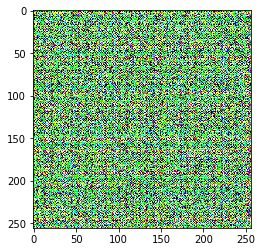

In [77]:
plt.imshow(np.floor(t*127 + 127).astype(np.int))
plt.show()